**IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [102]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
path = "/content/drive/MyDrive/9.RNN_Tasks/Data/Frozen_Dessert_Production.csv"

In [66]:
df = pd.read_csv(path, parse_dates = ["DATE"])

In [67]:
df.head(5)

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       573 non-null    datetime64[ns]
 1   IPN31152N  573 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.1 KB


**Change the column name to Production**

In [69]:
df.columns

Index(['DATE', 'IPN31152N'], dtype='object')

In [70]:
df = df.set_index('DATE')

In [71]:
df.columns = ['Production']

In [72]:
df.head(5)

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Plot out the time series**

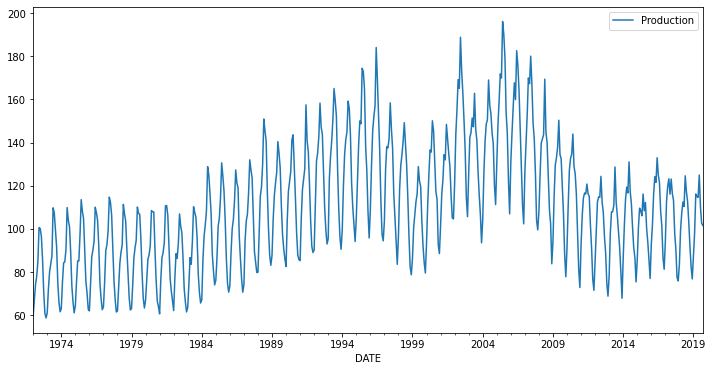

In [73]:
df.plot(figsize = (12, 6))
plt.show()

## Train Test Split

**Figure out the length of the data set**

In [74]:
len(df)

573

**Split the data into a train/test split where the test set is the last 24 months of data.**

In [75]:
test_size = 24

In [76]:
test_index  = len(df)-test_size
test_index

549

In [77]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [78]:
len(train)

549

In [79]:
len(test)

24

In [80]:
train.head(5)

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [81]:
test.head(5)

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899


## Scale Data

**Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [82]:
scaler = MinMaxScaler()

In [83]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [84]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [85]:
length = 18 #one shorter to the length of test data
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = batch_size)

**Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set**

In [86]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = batch_size)

### Create the Model

**Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [87]:
n_features = 1

In [88]:
# define model
model = Sequential()

# Simple RNN layer
#model.add(SimpleRNN(50,input_shape=(length, n_features))) #50 neurons

# LSTM 
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Create an EarlyStopping callback based on val_loss.**

In [89]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

**Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [90]:
model.fit_generator(generator, 
                    epochs = 25, 
                    validation_data = validation_generator, 
                    callbacks = [early_stop])

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


531/531 [==============================] - 6s 9ms/step - loss: 0.0203 - val_loss: 0.0019
Epoch 2/25
531/531 [==============================] - 4s 8ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 3/25
531/531 [==============================] - 5s 9ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 4/25
531/531 [==============================] - 5s 9ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/25
531/531 [==============================] - 5s 9ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 6/25
531/531 [==============================] - 5s 9ms/step - loss: 0.0032 - val_loss: 0.0026


**Plot the history of the loss that occured during training.**

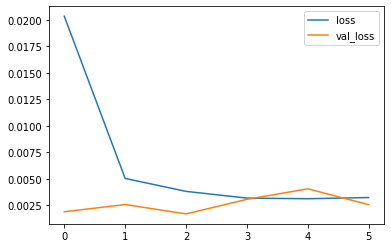

In [91]:
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.show()

In [92]:
losses

,loss,val_loss
0,0.020347,0.001897
1,0.005039,0.002576
2,0.003819,0.001692
3,0.003185,0.003068
4,0.003124,0.004059
5,0.003238,0.002565


## Evaluate on Test Data

**Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [93]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [94]:
true_predictions = scaler.inverse_transform(test_predictions)

In [95]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
test.head()

,Production,Predictions
DATE,,
2017-10-01,90.4732,87.224988
2017-11-01,77.4378,77.487108
2017-12-01,75.8118,76.383974
2018-01-01,83.4343,88.083978
2018-02-01,99.4899,100.398358


**Plot your predictions versus the True test values. (Your plot may look different than ours).**

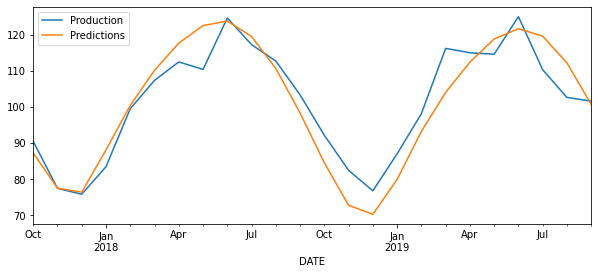

In [101]:
test.plot(figsize = (10, 4))
plt.show()

**Calculate your RMSE.**

In [103]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

6.058463630589887

**Retrain & Forecasting**

In [104]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [105]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [106]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')


# fit model
model.fit_generator(generator, epochs = 8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
561/561 [==============================] - 5s 6ms/step - loss: 0.0268
Epoch 2/8
561/561 [==============================] - 4s 6ms/step - loss: 0.0124
Epoch 3/8
561/561 [==============================] - 4s 6ms/step - loss: 0.0071
Epoch 4/8
561/561 [==============================] - 4s 7ms/step - loss: 0.0069
Epoch 5/8
561/561 [==============================] - 4s 7ms/step - loss: 0.0054
Epoch 6/8
561/561 [==============================] - 4s 6ms/step - loss: 0.0042
Epoch 7/8
561/561 [==============================] - 4s 6ms/step - loss: 0.0038
Epoch 8/8
561/561 [==============================] - 4s 7ms/step - loss: 0.0038


In [107]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [108]:
forecast = scaler.inverse_transform(forecast)

**Creating new timestamp index with pandas**

In [109]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [110]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS') #freq = 'MS' --> pandas frequency stings
# https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [111]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [112]:
forecast_df = pd.DataFrame(data = forecast,
                           index = forecast_index,
                           columns = ['Forecast'])

In [113]:
forecast_df

,Forecast
2019-10-01,87.611460
2019-11-01,80.283605
2019-12-01,77.747384
2020-01-01,83.044812
2020-02-01,93.481519
2020-03-01,103.816568
2020-04-01,109.916989
2020-05-01,115.663028
2020-06-01,117.152404
2020-07-01,110.565104


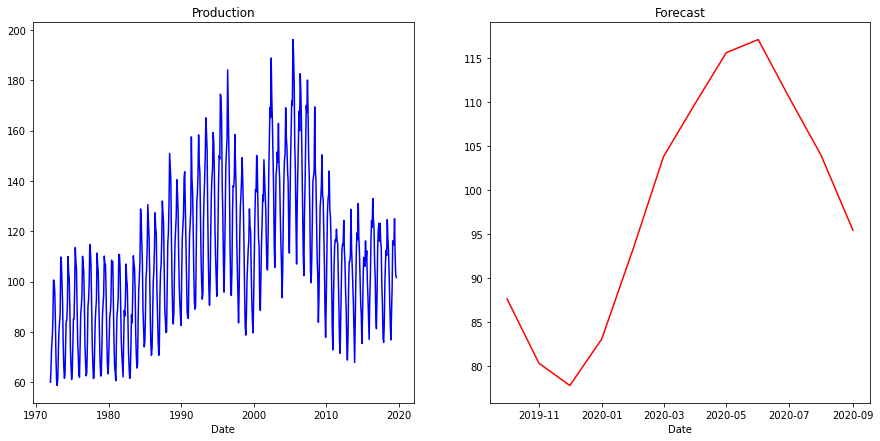

In [141]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))

axes[0].plot(df, 'b')

axes[1].plot(forecast_df, 'r')

#labels
axes[0].set_xlabel('Date')
axes[0].set_title('Production')

axes[1].set_xlabel('Date')
axes[1].set_title('Forecast')

plt.show()

**Joining Pandas Plot**

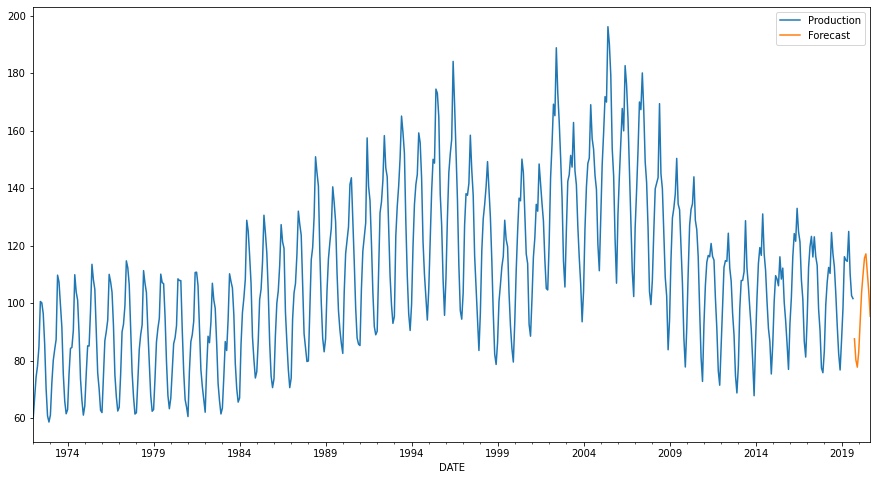

In [146]:
ax = df.plot()
forecast_df.plot(figsize = (15, 8), ax = ax)
plt.show()

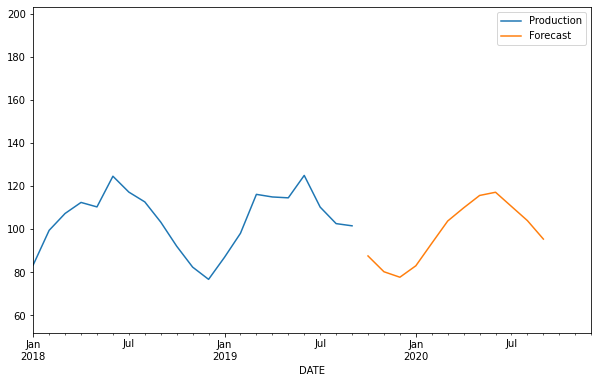

In [152]:
ax = df.plot()
forecast_df.plot(figsize = (10, 6), ax = ax)
plt.xlim('2018-01-01','2020-12-01	')
plt.show()